In [1]:
%load_ext autoreload
%autoreload 2
import io
import base64

from dash import Dash, html, Input, Output, dcc
from jupyter_dash import JupyterDash
import matplotlib.pyplot as plt

import sys

import numpy as np
import matplotlib
#matplotlib.use("agg") # no GUI
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
import mplhep.error_estimation
plt.style.use(hep.style.CMS)
import hist
import hist.plot
import hist.intervals

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

from cmsplots import cms_exp_text, plotFillBetweenHistogram

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v44'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}

In [3]:
h:hist.Hist = histStore.get(HistogramId("Clus3DSize", clueParams, "data")).getHistogram(HistogramKind.COUNT)
h[hist.loc(100), hist.loc("allTracksters"), :]

Hist(Integer(1, 100, name='clus3D_size_custom', label='3D cluster size ie number of 2D clusters that make out this 3D cluster'), storage=Double()) # Sum: 32601.0

In [4]:
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1(children='CLUE3D cluster size'),
    #dcc.Dropdown(options=beamEnergies, value=100, id='beamEnergy', clearable=False),
    dcc.Slider(min=beamEnergies[0], max=beamEnergies[-1], step=None, 
        marks={beamEnergy:f"{beamEnergy} GeV" for beamEnergy in beamEnergies},
        id="beamEnergy", value=100),
    #dcc.Slider(min=1, max=28, step=1, value=5, id="layer"),
    dcc.RadioItems(options={"default" : "Default", "ratio" : "Ratio"}, value="default", inline=True, id="ratioPlot"),
    dcc.RadioItems(options=["mainTrackster", "allTracksters"], value="mainTrackster", inline=True, id="mainOrAllTracksters"),
    dcc.RadioItems(options=["Count", "Weight"], value="Count", inline=True, id="histogramKind"),
    html.Img(id="plot")
])

def shiftHistogram(h:hist.Hist):
    vals, edges = h.to_numpy()
    edges -= 0.5
    return vals, edges

def fixNanInPoissonIntervals(intervals):
    """ replace nan with 0 in lower bounds (fix a bug in mplhep.uncertainties) """
    return np.stack([np.nan_to_num(intervals[0]), intervals[1]])


def loadHists(beamEnergy:int, datatypes:list[str], mainOrAllTracksters, kind) -> tuple[list[hist.Hist], list[str]]:
    return [(histStore
        .get(HistogramId("Clus3DSize", clueParams, datatype))
        .getHistogram(kind)[{
            "beamEnergy" : hist.loc(beamEnergy),
            "mainOrAllTracksters" : hist.loc(mainOrAllTracksters),
            #"layer" : hist.loc(layer),
        }]
        .project("clus3D_size_custom")
        ) for datatype in datatypes], [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]

def addLumiLegend(main_ax, datatypes, beamEnergy, legend=True, cmstext_loc=0, lumi_loc="default"):
    cmstext = "Preliminary" if "data" in datatypes else "Simulation Preliminary"
    cms_exp_text(cmstext, loc=cmstext_loc, ax=main_ax)
    
    text = f"$e^+$ TB - {str(beamEnergy)} GeV"
    #hep.cms.lumitext(text, ax=main_ax)
    if lumi_loc == "default":
        text_kwargs = dict(x=1, y=1.005, va="bottom")
    elif lumi_loc == "top right" and cmstext_loc != 4:
        text_kwargs = dict(x=0.95, y=0.95, va="top")
    elif lumi_loc == "top right" and cmstext_loc == 4:
        text_kwargs = dict(x=0.95, y=0.81, va="top")
    else:
        raise ValueError()
    main_ax.text(
        s=text,
        transform=main_ax.transAxes,
        ha="right",
        fontsize=matplotlib.rcParams["font.size"] * 0.95,
        fontweight="normal",
        fontname="TeX Gyre Heros",
        **text_kwargs
    )
    
    legend_kwargs = dict(loc="upper right", bbox_to_anchor=(0.95, 0.9 if cmstext_loc != 4 else 0.75) )
    if legend is True:
        main_ax.legend(**legend_kwargs)
    elif legend == "data_first":
        main_ax.legend(handles=main_ax.get_legend_handles_labels()[0][::-1], **legend_kwargs)

def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

def makePlotMultiDatatype(beamEnergy:int, datatypes:list[str], mainOrAllTracksters, kind, dataAsMarkers=False):
    hists, labels = loadHists(beamEnergy, datatypes, mainOrAllTracksters, kind=kind)
    yerr = False

    if kind is HistogramKind.COUNT: # Normalize MC to data counts
        for i in range(len(datatypes)):
            if i == 0:
                count_data = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
    
    #fig = plt.Figure()
    fig = plt.figure()
    ax = fig.subplots()
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    ax.set_xlim(0, 6)
    
    #ax.set_ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    #ax.set_yscale("log")
    if dataAsMarkers:
        hep.histplot(hists[1:], label=labels[1:], yerr=False)
        hep.histplot(hists[0], label=labels[0], histtype="errorbar", yerr=True, color="black")
    else:
        hep.histplot(hists, label=labels, yerr=yerr, ax=ax)

    ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("Number of layer clusters in a trackster")
    ax.set_xlim(right=70)
    if kind is HistogramKind.COUNT:
        ax.set_ylabel("Trackster count")
    elif kind is HistogramKind.WEIGHT:
        ax.set_ylabel("Sum of trackster energies in each size bin (GeV)")

    addLumiLegend(ax, datatypes, beamEnergy, legend="data_first" if dataAsMarkers else True, cmstext_loc=2, lumi_loc="top right")
    return fig

def makePlotNbOfLCInTrackster_definitive(beamEnergy, alpha=0.5, mainOrAllTracksters="allTracksters"):
    """ Definitive version with less settings """
    [h_data, h_sim_raw], labels = loadHists(beamEnergy, ["data", "sim_proton_v46_patchMIP"], mainOrAllTracksters, kind=HistogramKind.COUNT)
    # Normalize MC to data counts
    count_data = h_data.sum(flow=True)
    h_sim = countHistogramToWeightHistogram(h_sim_raw) * (count_data / h_sim_raw.sum(flow=True))
    
    fig = plt.figure()
    ax = fig.subplots()
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    
    plotFillBetweenHistogram(h_sim, ax=ax, shift=-1, alpha=alpha)
    artist_sim_line, = hep.histplot(h_sim, label="Simulation", yerr=False)
    artist_data, = hep.histplot(h_data, label="Data", histtype="errorbar", yerr=True, color="black")

    ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    class IntegerAxisFormatter(matplotlib.ticker.ScalarFormatter):
        def __call__(self, x: float, pos: int = ...) -> str:
            return super().__call__(x+0.5, pos)
    ax.xaxis.set_major_formatter(IntegerAxisFormatter())
    ax.set_xlabel("Number of layer clusters in a trackster")
    ax.set_xlim(left=0, right=60)
    ax.set_ylabel("Trackster count")

    cms_exp_text("Preliminary", loc=2, ax=ax)
    
    text = f"$e^+$ Test Beam\n{str(beamEnergy)} GeV\n"
    if mainOrAllTracksters == "allTracksters":
        text += "All tracksters"
    else:
        text += "Main trackster"
    text_kwargs = dict(x=0.05, y=0.75, va="top")
    ax.text(
        s=text,
        transform=ax.transAxes,
        ha="left",
        fontsize=matplotlib.rcParams["font.size"] * 0.9,
        fontweight="normal",
        fontname="TeX Gyre Heros",
        **text_kwargs
    )
    #return (artist_sim_line, matplotlib.patches.Patch(color="tab:blue", alpha=0.5, linewidth=0))
    ax.legend(handles=[artist_data.errorbar, (artist_sim_line.stairs, matplotlib.patches.Patch(color="tab:blue", alpha=alpha, linewidth=0))],
              labels=["Data", "Simulation"],
              loc="upper left", bbox_to_anchor=(0., 0.5))
    
    #return fig

def makePlotNbOfLCInTrackster_ratio(beamEnergy, alpha=0.5, mainOrAllTracksters="allTracksters", ratioUncertaintyMode="data-rescaling"):
    """ Definitive version with less settings 
    Parameters : 
     - ratioUncertaintyMode : can be either
         - data-rescaling : rescale data to MC counts in ratio plot, and rescale MC to itself (so the mean of MC is always 1)
         - poisson-ratio : ratio plot is confidence interval of ratio of poisson data and poisson MC (rescaled for nb of events)
    """
    [h_data, h_sim_raw], labels = loadHists(beamEnergy, ["data", "sim_proton_v46_patchMIP"], mainOrAllTracksters, kind=HistogramKind.COUNT)
    # Normalize MC to data counts
    count_data = h_data.sum(flow=True)
    h_sim = countHistogramToWeightHistogram(h_sim_raw) * (count_data / h_sim_raw.sum(flow=True))
    
    fig = plt.figure(figsize=(8, 9))
    grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

    main_ax = fig.add_subplot(grid[0])
    subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    ax = main_ax
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    
    plotFillBetweenHistogram(h_sim, ax=ax, shift=-0.5, alpha=alpha)
    artist_sim_line, = hep.histplot(shiftHistogram(h_sim), label="Simulation", yerr=False, ax=ax)
    artist_data, = hep.histplot(shiftHistogram(h_data), label="Data", histtype="errorbar", yerr=True, color="black", ax=ax)

    subplot_ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    class IntegerAxisFormatter(matplotlib.ticker.ScalarFormatter):
        def __call__(self, x: float, pos: int = ...) -> str:
            return super().__call__(x+0.5, pos)
    #subplot_ax.xaxis.set_major_formatter(IntegerAxisFormatter())
    subplot_ax.set_xlim(left=0.5, right=60.5)
    ax.set_ylabel("Trackster count")

    # cms_exp_text("Preliminary", loc=2, ax=ax)
    
    # text = f"$e^+$ Test Beam\n{str(beamEnergy)} GeV"
    # text_kwargs = dict(x=0.05, y=0.75, va="top")
    # ax.text(
    #     s=text,
    #     transform=ax.transAxes,
    #     ha="left",
    #     fontsize=matplotlib.rcParams["font.size"] * 0.9,
    #     fontweight="normal",
    #     fontname="TeX Gyre Heros",
    #     **text_kwargs
    # )

    hep.cms.text("Preliminary", ax=main_ax)
    hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)
    text = f"{beamEnergy} GeV\n"
    if mainOrAllTracksters == "allTracksters":
        text += "All CLUE3D\ntracksters"
    else:
        text += "Main CLUE3D\ntrackster"
    main_ax.text(
        s=text,
        transform=ax.transAxes,
        ha="left",
        fontsize=matplotlib.rcParams["font.size"] * 0.95,
        fontweight="normal",
        fontname="TeX Gyre Heros",
        x=0.05, y=0.95, va="top"
    )

    #return (artist_sim_line, matplotlib.patches.Patch(color="tab:blue", alpha=0.5, linewidth=0))
    ax.legend(handles=[artist_data.errorbar, (artist_sim_line.stairs, matplotlib.patches.Patch(color="tab:blue", alpha=alpha, linewidth=0))],
              labels=["Data", "Simulation"],
              loc="upper left", bbox_to_anchor=(0., 0.75))
    
    # Making ratio
    subplot_ax.axhline(1, color="black", linestyle="--")

    if ratioUncertaintyMode == "data-rescaling":
        # Rescaling poisson interval for sim : used for rescaling data and sim separately
        poisIntervalsSimRaw = fixNanInPoissonIntervals(hep.error_estimation.poisson_interval(h_sim_raw.values(), h_sim_raw.values()))

        plotFillBetweenHistogram((np.ones_like(h_sim_raw.values()), h_sim_raw.axes[0].edges), ax=subplot_ax, shift=True, alpha=alpha, confidenceIntervals=poisIntervalsSimRaw/h_sim_raw.values())

        # Markers for data, rescaling poisson errors as well
        poisIntervalsData = fixNanInPoissonIntervals(hep.error_estimation.poisson_interval(h_data.values(), h_data.values()))
        subplot_ax.errorbar(x=h_data.axes[0].centers-0.5, y=h_data.values()/h_sim.values(), yerr=np.nan_to_num(np.abs(poisIntervalsData - h_data.values())/h_sim.values()),
                            fmt="o", color="black")

    elif ratioUncertaintyMode == "poisson-ratio":
        ### Misses normalizing to data counts
        ratio_uncert = hist.intervals.ratio_uncertainty(h_data.values(), h_sim_raw.values(), uncertainty_type="poisson-ratio")
        ratio_vals = h_data.values()/h_sim.values()
        subplot_ax.errorbar(x=h_data.axes[0].centers-1, y=ratio_vals, yerr=ratio_uncert,
                            fmt="o", color="black")

    subplot_ax.set_ylabel("Data / MC")
    subplot_ax.set_ylim(0, 3)
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel("Number of layer clusters in a trackster")

    subplot_ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([0, 1, 2]))

def mplFigureToUrl(fig=None):
    if fig is None:
        fig = plt.gcf()
    buf = io.BytesIO() # in-memory files
    fig.savefig(buf, format="png")
    plt.close(fig)
    data = base64.b64encode(buf.getbuffer()).decode("utf8") # encode to html elements
    buf.close()
    return "data:image/png;base64,{}".format(data)


@app.callback(
    Output(component_id='plot', component_property='src'),
    [Input(component_id = 'beamEnergy', component_property='value'),Input("ratioPlot", "value"),
    Input("mainOrAllTracksters", "value"), Input("histogramKind", "value")
    ]
)
def update_graph(beamEnergy, ratioPlot:bool, mainOrAllTracksters:str, histogramKind:str):
    if histogramKind == "Count":
        kind = HistogramKind.COUNT
    else:
        kind = HistogramKind.WEIGHT
    if ratioPlot == "ratio":
        pass
        #fig = makePlotRatio(layer, beamEnergy=beamEnergy, datatypes=["data", "sim_proton_v46_patchMIP"])
    else:
        fig = makePlotMultiDatatype(beamEnergy=beamEnergy, datatypes=["data", "sim_proton_v46_patchMIP"], mainOrAllTracksters=mainOrAllTracksters,
            kind=kind)
    return mplFigureToUrl(fig)


/grid_mnt/data_cms_upgrade/cuisset/conda/envs/clustering-analysis/lib/python3.11/site-packages/dash/dash.py:538: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [21]:
# if __name__ == '__main__':
#     #app.run_server(mode="inline")
#     app.run_server(debug=True)

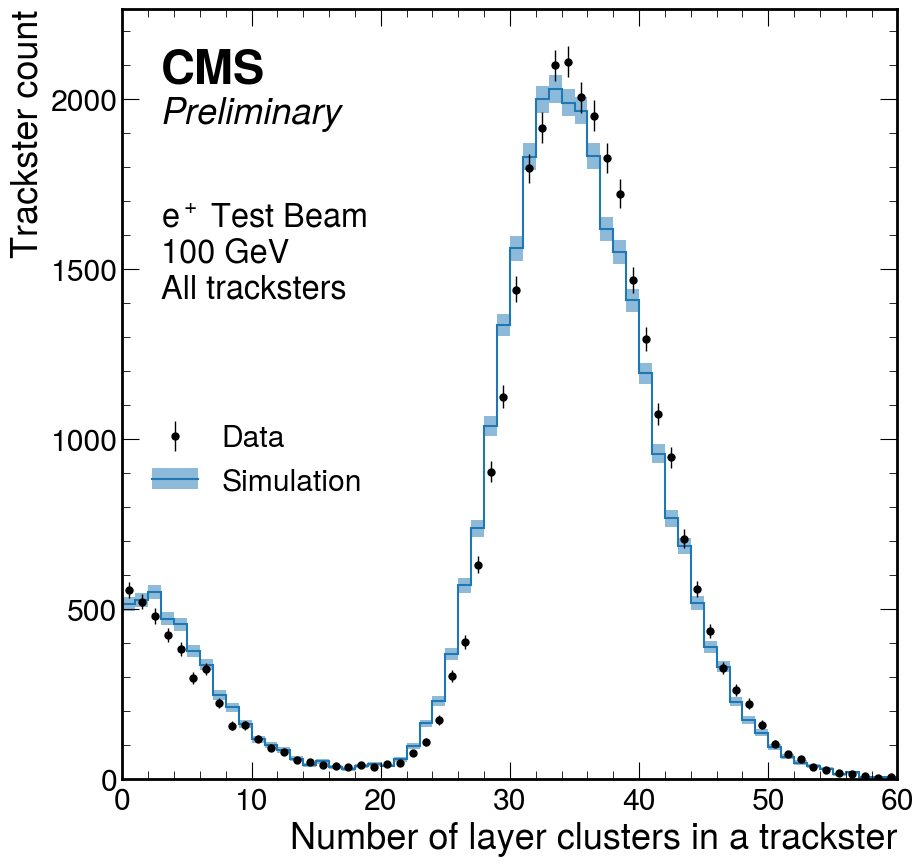

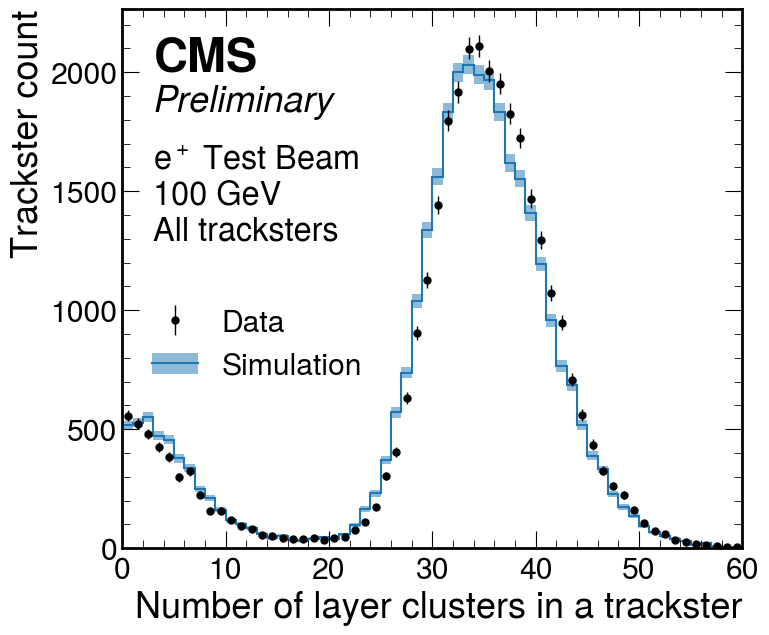

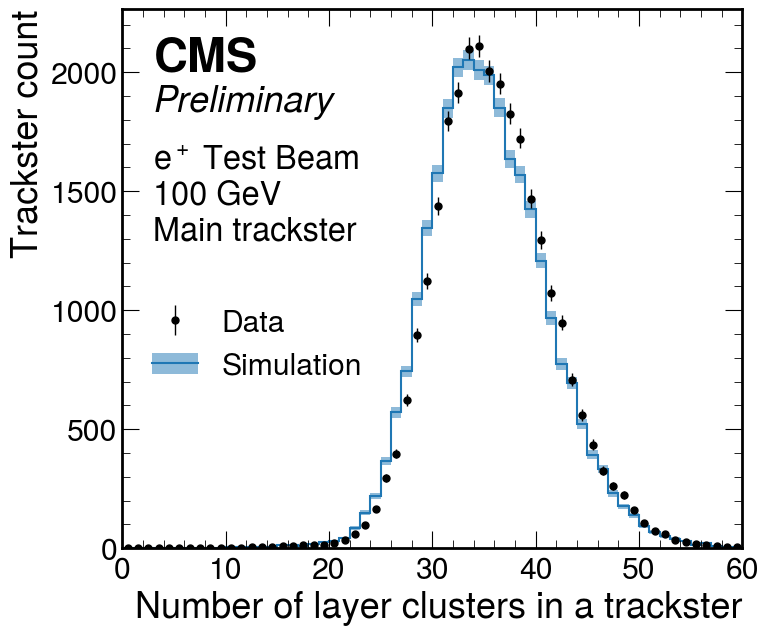

In [5]:
#makePlotMultiDatatype(100, datatypes=["data", "sim_proton_v46_patchMIP"], mainOrAllTracksters="allTracksters",
#            kind=HistogramKind.COUNT, dataAsMarkers=True)
makePlotNbOfLCInTrackster_definitive(100)
plt.savefig("plots/tracksterProps/tracksterSize/100.pdf", bbox_inches="tight")
with matplotlib.rc_context({"figure.figsize" : (8, 7)}):
    makePlotNbOfLCInTrackster_definitive(100)
    plt.savefig("plots/tracksterProps/tracksterSize/100_small.pdf", bbox_inches="tight")
    makePlotNbOfLCInTrackster_definitive(100, mainOrAllTracksters="mainTrackster")
    plt.savefig("plots/tracksterProps/tracksterSize/100_mainTrackster_small.pdf", bbox_inches="tight")


(0.0, 400.0)

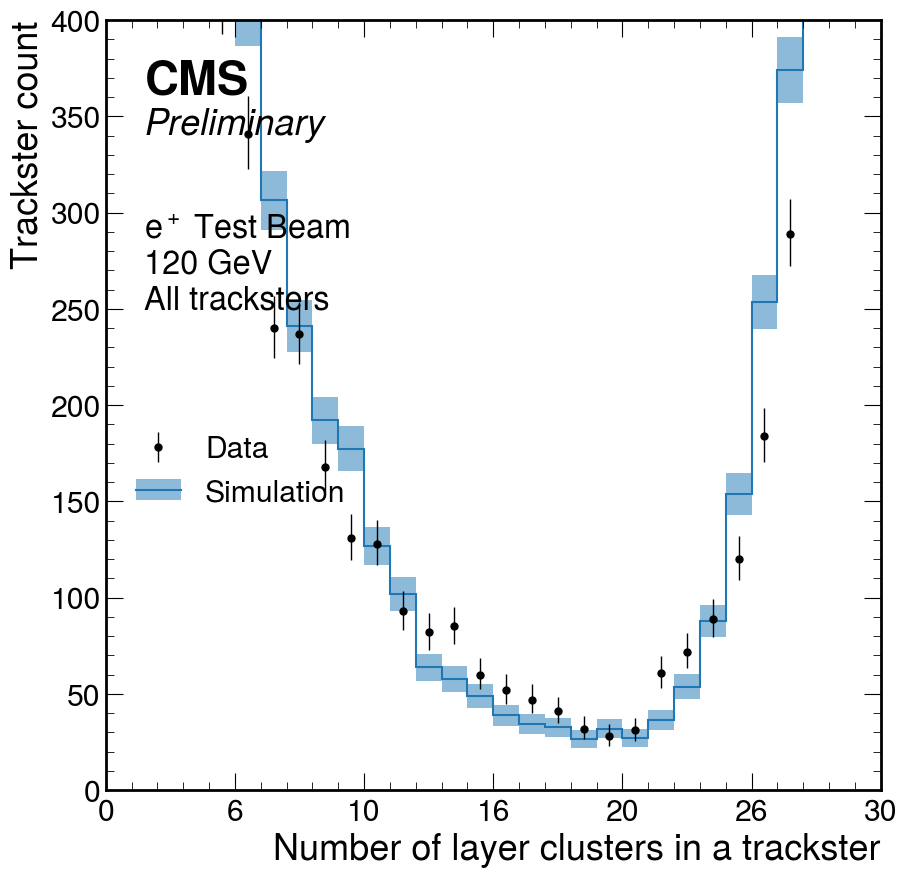

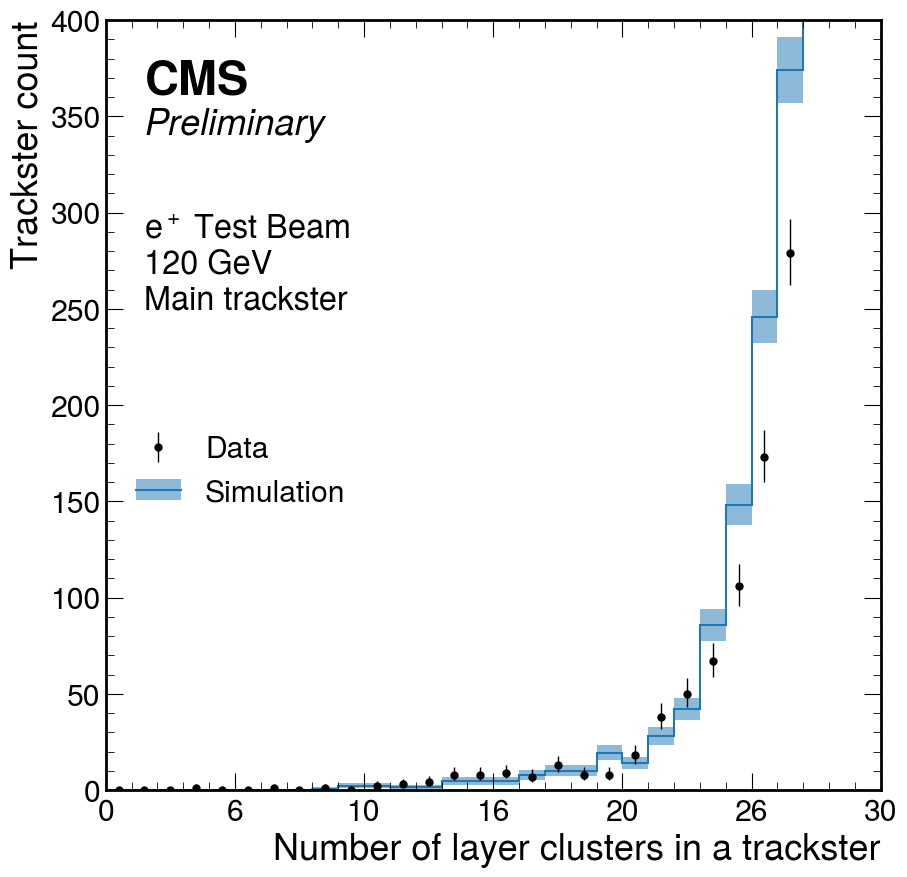

In [23]:
# zoomed version
makePlotNbOfLCInTrackster_definitive(120)
plt.xlim(0, 30)
plt.ylim(0, 400)
makePlotNbOfLCInTrackster_definitive(120, mainOrAllTracksters="mainTrackster")
plt.xlim(0, 30)
plt.ylim(0, 400)

/tmp/ipykernel_157175/2342529272.py:236: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2342529272.py:236: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_157175/2342529272.py:240: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_157175/2342529272.py:240: RuntimeWarning:

divide by zero encountered in divide



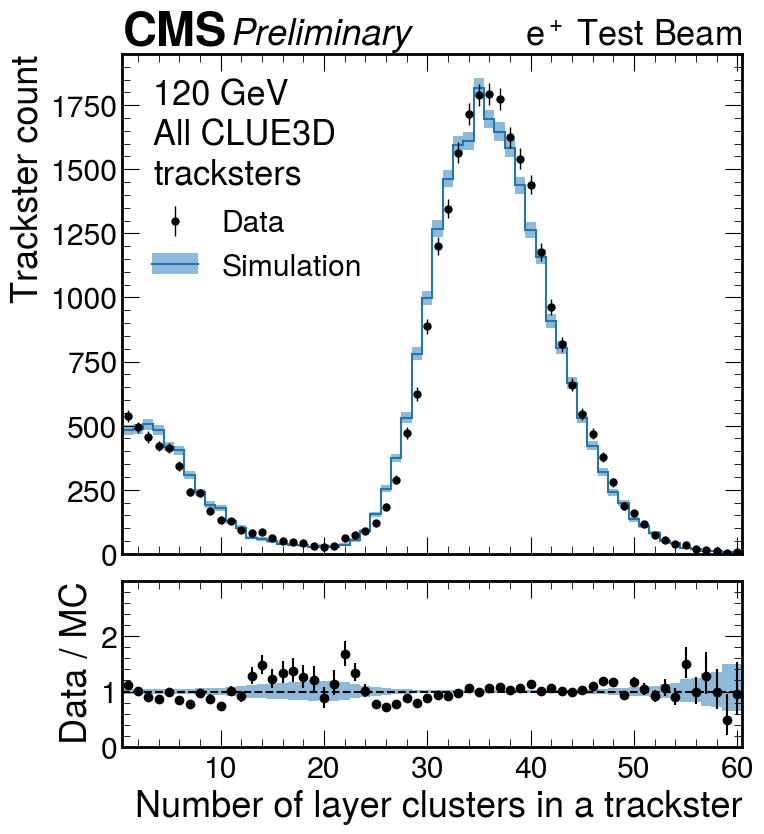

In [24]:
makePlotNbOfLCInTrackster_ratio(120)

/tmp/ipykernel_157175/2342529272.py:236: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2342529272.py:236: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_157175/2342529272.py:240: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_157175/2342529272.py:240: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2342529272.py:236: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2342529272.py:236: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_157175/2342529272.py:240: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2342529272.py:240: RuntimeWarning:

invalid value encountered in divide



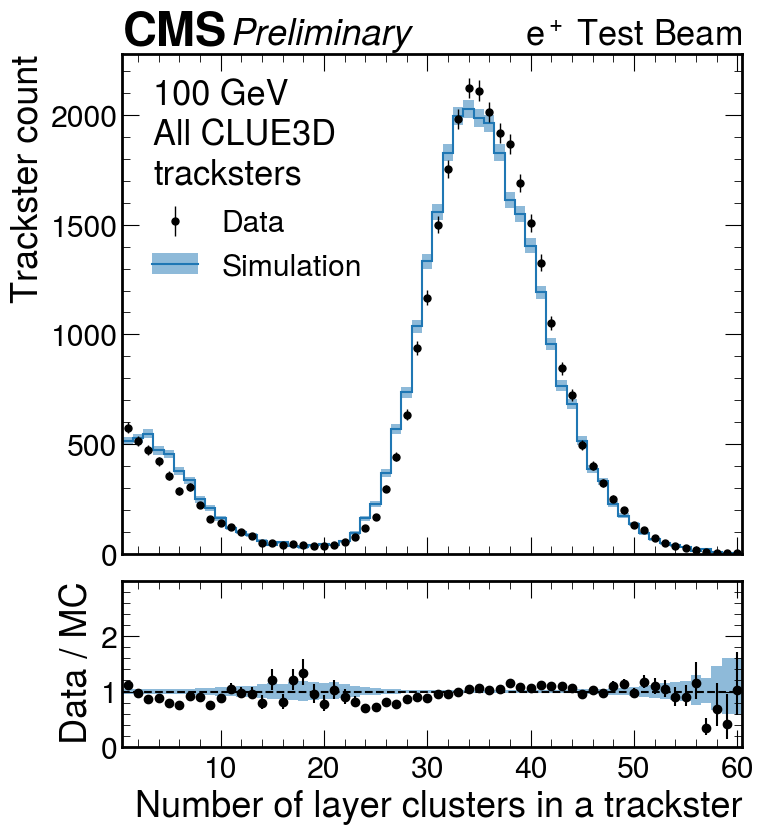

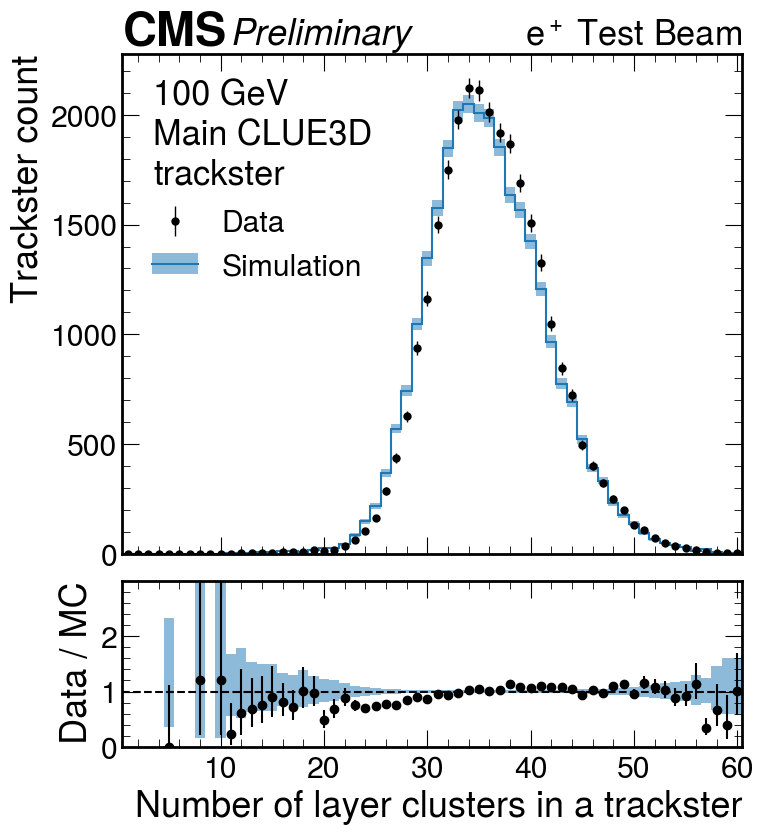

In [25]:
makePlotNbOfLCInTrackster_ratio(100)
plt.savefig("plots/tracksterProps/tracksterSize/100_ratio.pdf", bbox_inches="tight")
makePlotNbOfLCInTrackster_ratio(100, mainOrAllTracksters="mainTrackster")
#plt.ylim(0, 2)
plt.savefig("plots/tracksterProps/tracksterSize/100_mainTrackster_ratio.pdf", bbox_inches="tight")

In [9]:
[h_data, h_sim_raw], labels = loadHists(100, ["data", "sim_proton_v46_patchMIP"], "allTracksters", kind=HistogramKind.COUNT)
#hep.error_estimation.poisson_interval([1, 2,  0], [1, 2, 0])
h_data.values(), h_sim_raw.values()

(array([6.530e+02, 5.610e+02, 5.290e+02, 4.780e+02, 4.180e+02, 3.310e+02,
        3.350e+02, 2.530e+02, 1.860e+02, 1.610e+02, 1.460e+02, 1.190e+02,
        1.040e+02, 9.500e+01, 1.070e+02, 7.700e+01, 8.500e+01, 7.700e+01,
        7.000e+01, 5.900e+01, 6.700e+01, 8.100e+01, 9.700e+01, 1.390e+02,
        1.950e+02, 3.360e+02, 5.060e+02, 6.940e+02, 1.022e+03, 1.280e+03,
        1.632e+03, 1.901e+03, 2.145e+03, 2.305e+03, 2.281e+03, 2.195e+03,
        2.093e+03, 2.044e+03, 1.840e+03, 1.659e+03, 1.456e+03, 1.174e+03,
        9.280e+02, 7.920e+02, 5.460e+02, 4.520e+02, 3.600e+02, 2.820e+02,
        2.190e+02, 1.480e+02, 1.150e+02, 8.100e+01, 5.600e+01, 4.000e+01,
        3.500e+01, 1.900e+01, 7.000e+00, 7.000e+00, 2.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

In [11]:
(h_data/h_sim_raw).values()

array([1.03159558, 0.86574074, 0.7837037 , 0.82413793, 0.74776386,
       0.71490281, 0.81113801, 0.8295082 , 0.71814672, 0.80904523,
       1.01388889, 0.96747967, 0.98113208, 1.28378378, 2.09803922,
       1.203125  , 1.93181818, 2.13888889, 1.45833333, 1.07272727,
       1.36734694, 1.14084507, 0.8220339 , 0.69154229, 0.69148936,
       0.74172185, 0.72285714, 0.76600442, 0.80094044, 0.7804878 ,
       0.8513302 , 0.84526456, 0.87372709, 0.92421812, 0.93368809,
       0.9092792 , 0.93022222, 1.02868646, 0.96587927, 0.95951417,
       0.99317872, 0.99829932, 0.985138  , 0.94061758, 0.85984252,
       0.9475891 , 0.88669951, 1.00714286, 1.02816901, 0.88622754,
       1.        , 1.        , 0.93333333, 0.83333333, 0.92105263,
       1.11764706, 0.28      , 0.77777778, 0.33333333, 0.83333333,
       1.        , 0.5       , 0.        ,        nan,        nan,
              nan, 0.        ,        nan,        nan, 0.        ,
              nan,        nan, 0.        ,        nan,        

In [16]:
fixNanInPoissonIntervals(hist.intervals.ratio_uncertainty(h_data.values(), h_sim_raw.values(), uncertainty_type="poisson-ratio"))

array([[0.06377331, 0.05533441, 0.05043806, 0.05641745, 0.05357748,
        0.05700138, 0.06605658, 0.0780766 , 0.07635717, 0.09479957,
        0.13147219, 0.13722824, 0.14924374, 0.21883747, 0.39116103,
        0.22341065, 0.39232367, 0.47082608, 0.29909186, 0.22030576,
        0.2813344 , 0.20380188, 0.12422532, 0.08431976, 0.07126226,
        0.05915398, 0.04675019, 0.04283949, 0.03728476, 0.03228453,
        0.03180362, 0.02921143, 0.0286451 , 0.02962134, 0.03015563,
        0.02974737, 0.03133505, 0.03594664, 0.03501805, 0.03657502,
        0.04075397, 0.04567236, 0.05051808, 0.05161852, 0.05561768,
        0.068912  , 0.07109607, 0.09403648, 0.1094187 , 0.11052488,
        0.14542151, 0.17283546, 0.19015384, 0.19499708, 0.23504738,
        0.39846048, 0.12733557, 0.4037573 , 0.25967135, 0.50386515,
        0.85723091, 0.4890323 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [26]:
def loadHistsNbTrackster(beamEnergy:int, datatypes:list[str], kind=HistogramKind.COUNT) -> tuple[list[hist.Hist], list[str]]:
    return [(histStore
        .get(HistogramId("Clus3DNbOfTrackstersPerEvent", clueParams, datatype))
        .getHistogram(kind)[{
            "beamEnergy" : hist.loc(beamEnergy),
        }]
        #.project("clus3D_size_custom")
        ) for datatype in datatypes], [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]


def nbOfTracksterPerEvent(beamEnergy, datatypes, kind=HistogramKind.COUNT, log=False, dataAsMarkers=False):
    hists_, labels = loadHistsNbTrackster(beamEnergy, datatypes)
    yerr = False

    if kind is HistogramKind.COUNT: # Normalize MC to data counts
        for i in range(len(datatypes)):
            if i == 0:
                count_data = hists_[0].sum(flow=True)
            else:
                hists_[i] = countHistogramToWeightHistogram(hists_[i]) * (count_data / hists_[i].sum(flow=True))
    hists = [shiftHistogram(h) for h in hists_]
    #fig = plt.Figure()
    fig = plt.figure()
    ax = fig.subplots()
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    #ax.set_xlim(0, 6)
    
    #ax.set_ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    #ax.set_yscale("log")
    if dataAsMarkers:
        for h in hists_[1:]:
            plotFillBetweenHistogram(h, ax=ax, shift=True, alpha=0.5)
        hep.histplot(hists[1:], label=labels[1:], yerr=False)
        hep.histplot(hists[0], label=labels[0], histtype="errorbar", yerr=True, color="black")
    else:
        hep.histplot(hists, label=labels, yerr=yerr, ax=ax)

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.set_xlabel("Number of tracksters per event")
    if log:
        ax.set_yscale("log")
        ax.set_xlim(0.5, 10.5)
    else:
        ax.set_xlim(0.5,10.5)
    #ax.set_xlim(right=70)
    if kind is HistogramKind.COUNT:
        ax.set_ylabel("Event count")
    elif kind is HistogramKind.WEIGHT:
        ax.set_ylabel("Sum of 3D cluster energies in each size bin (GeV)")

    addLumiLegend(ax, datatypes, beamEnergy, legend="data_first" if dataAsMarkers else True, cmstext_loc=4, lumi_loc="top right")

In [27]:
def nbOfTracksterPerEvent_definitive(beamEnergy, log=True, alpha=0.5):
    """ Version for definitive plots (less settings, better legend) """
    sim_datatype = "sim_proton_v46_patchMIP"
    (h_data, h_sim_raw), labels = loadHistsNbTrackster(beamEnergy, ["data", sim_datatype])
    # Normalize MC to data counts
    count_data = h_data.sum(flow=True)
    h_sim = countHistogramToWeightHistogram(h_sim_raw) * (count_data / h_sim_raw.sum(flow=True))

    fig = plt.figure()
    ax = fig.subplots()
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    #ax.set_xlim(0, 6)
    
    #ax.set_ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    #ax.set_yscale("log")
    plotFillBetweenHistogram(h_sim, ax=ax, shift=True, alpha=alpha)
    artist_sim_line, = hep.histplot(shiftHistogram(h_sim), label="Simulation", yerr=False)
    artist_data, = hep.histplot(shiftHistogram(h_data), label="Data", histtype="errorbar", yerr=True, color="black")
    #return artist_data
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.set_xlabel("Number of tracksters per event")
    if log:
        ax.set_yscale("log")
        ax.set_xlim(0.5, 10.5)
    else:
        ax.set_xlim(0.5,10.5)
    #ax.set_xlim(right=70)
    ax.set_ylabel("Event count")

    cms_exp_text("Preliminary", loc=5, ax=ax)
    
    text = f"$e^+$ Test Beam\n{str(beamEnergy)} GeV"
    text_kwargs = dict(x=0.95, y=0.77, va="top")
    ax.text(
        s=text,
        transform=ax.transAxes,
        ha="right",
        fontsize=matplotlib.rcParams["font.size"] * 0.95,
        fontweight="normal",
        fontname="TeX Gyre Heros",
        **text_kwargs
    )
    #return (artist_sim_line, matplotlib.patches.Patch(color="tab:blue", alpha=0.5, linewidth=0))
    ax.legend(handles=[artist_data.errorbar, (artist_sim_line.stairs, matplotlib.patches.Patch(color="tab:blue", alpha=alpha, linewidth=0))],
              labels=["Data", "Simulation"],
              loc="upper right", bbox_to_anchor=(0.98, 0.65))
    return artist_data


def nbOfTracksterPerEvent_ratio(beamEnergy, log=True, alpha=0.5):
    """ Version for definitive plots (less settings, better legend) with ratio plot """
    sim_datatype = "sim_proton_v46_patchMIP"
    (h_data, h_sim_raw), labels = loadHistsNbTrackster(beamEnergy, ["data", sim_datatype])
    # Normalize MC to data counts
    count_data = h_data.sum(flow=True)
    h_sim = countHistogramToWeightHistogram(h_sim_raw) * (count_data / h_sim_raw.sum(flow=True))
     # Rescaling poisson interval for simulation to data counts
    poisIntervalsSimRaw = fixNanInPoissonIntervals(hep.error_estimation.poisson_interval(h_sim_raw.values(), h_sim_raw.values()))
    poisIntervalsSim = poisIntervalsSimRaw * (count_data / h_sim_raw.sum(flow=True))

    fig = plt.figure(figsize=(8, 9))
    grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

    main_ax = fig.add_subplot(grid[0])
    subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    ax = main_ax
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    #ax.set_xlim(0, 6)
    
    #ax.set_ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    #ax.set_yscale("log")
    # np.nan_to_num(np.abs(poisIntervalsSimRaw - h_sim_raw.values())* (count_data / h_sim_raw.sum(flow=True)))
    plotFillBetweenHistogram(h_sim, ax=ax, shift=True, alpha=alpha, confidenceIntervals=poisIntervalsSim)
    artist_sim_line, = hep.histplot(shiftHistogram(h_sim), label="Simulation", yerr=False, ax=ax)
    artist_data, = hep.histplot(shiftHistogram(h_data), label="Data", histtype="errorbar", yerr=True, color="black", ax=ax)
    #return artist_data
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.set_xlabel("")
    if log:
        ax.set_yscale("log")
        ax.set_xlim(0.5, 10.5)
    else:
        ax.set_xlim(0.5,10.5)
    #ax.set_xlim(right=70)
    ax.set_ylabel("Event count")
    ax.set_ylim(bottom=0.5)

    hep.cms.text("Preliminary", ax=main_ax)
    hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)
    main_ax.text(
        s=f"{beamEnergy} GeV",
        transform=ax.transAxes,
        ha="right",
        fontsize=matplotlib.rcParams["font.size"] * 0.95,
        fontweight="normal",
        fontname="TeX Gyre Heros",
        x=0.95, y=0.95, va="top"
    )
    #return (artist_sim_line, matplotlib.patches.Patch(color="tab:blue", alpha=0.5, linewidth=0))
    ax.legend(handles=[artist_data.errorbar, (artist_sim_line.stairs, matplotlib.patches.Patch(color="tab:blue", alpha=alpha, linewidth=0))],
              labels=["Data", "Simulation"],
              loc="upper right", bbox_to_anchor=(0.98, 0.9))
    
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel("Number of tracksters per event")

    # Making ratio
    subplot_ax.axhline(1, color="black", linestyle="--")

    plotFillBetweenHistogram((np.ones_like(h_sim_raw.values()), h_sim_raw.axes[0].edges), ax=subplot_ax, shift=True, alpha=alpha, confidenceIntervals=poisIntervalsSimRaw/h_sim_raw.values())

    # Markers for data, rescaling poisson errors as well
    poisIntervalsData = fixNanInPoissonIntervals(hep.error_estimation.poisson_interval(h_data.values(), h_data.values()))
    subplot_ax.errorbar(x=h_data.axes[0].centers-0.5, y=h_data.values()/h_sim.values(), yerr=np.nan_to_num(np.abs(poisIntervalsData - h_data.values())/h_sim.values()),
                        fmt="o", color="black")
    
    subplot_ax.set_ylabel("Data / MC")
    subplot_ax.set_ylim(0, 2)

    subplot_ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([0, 1, 2]))

    return artist_data

In [28]:
(h_data, h_sim_raw), labels = loadHistsNbTrackster(100, ["data", "sim_proton_v46_patchMIP"])
# Normalize MC to data counts
count_data = h_data.sum(flow=True)
h_sim = countHistogramToWeightHistogram(h_sim_raw) * (count_data / h_sim_raw.sum(flow=True))
    # Rescaling poisson interval for simulation to data counts
poisIntervalsSimRaw = fixNanInPoissonIntervals(hep.error_estimation.poisson_interval(h_sim_raw.values(), h_sim_raw.values()))
poisIntervalsSim = poisIntervalsSimRaw * (count_data / h_sim_raw.sum(flow=True))

In [16]:
h_sim[7]

WeightedSum(value=2.7121, variance=2.45183)

In [24]:
poisIntervalsSim[:, 7] - h_sim[7].value

array([-1.47601908,  2.63813658])

In [27]:
(poisIntervalsSimRaw/h_sim_raw.values())[:, 7]-1

/tmp/ipykernel_197167/535199656.py:1: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_197167/535199656.py:1: RuntimeWarning:

invalid value encountered in divide



array([-0.5442349 ,  0.97272861])

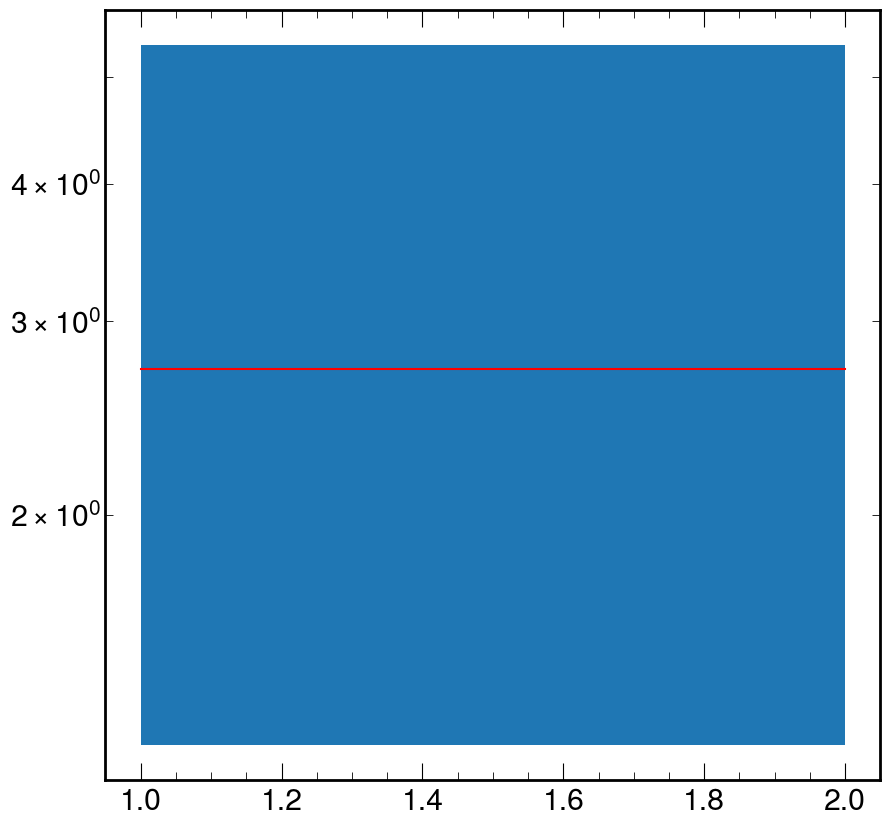

In [23]:

plt.fill_between([1, 2], [poisIntervalsSim[0, 7]]*2, [poisIntervalsSim[1, 7]]*2)
plt.plot([1, 2], [h_sim[7].value]*2, color="red")
plt.yscale("log")

In [13]:
vals = np.array([1, 0, 2])
hep.error_estimation.poisson_interval(vals, vals)

array([[0.17275378,        nan, 0.70818544],
       [3.29952656, 1.84102165, 4.63785962]])

/tmp/ipykernel_157175/2305066219.py:115: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2305066219.py:115: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_157175/2305066219.py:119: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_157175/2305066219.py:119: RuntimeWarning:

invalid value encountered in divide



<Figure size 1000x1000 with 0 Axes>

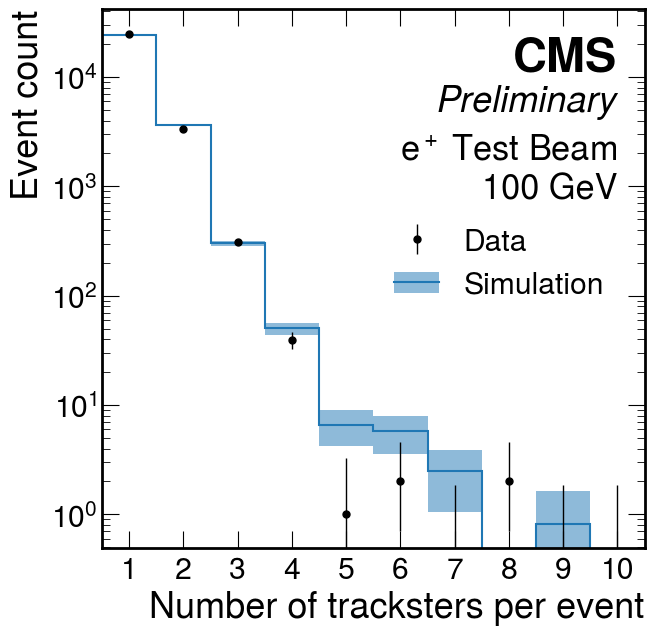

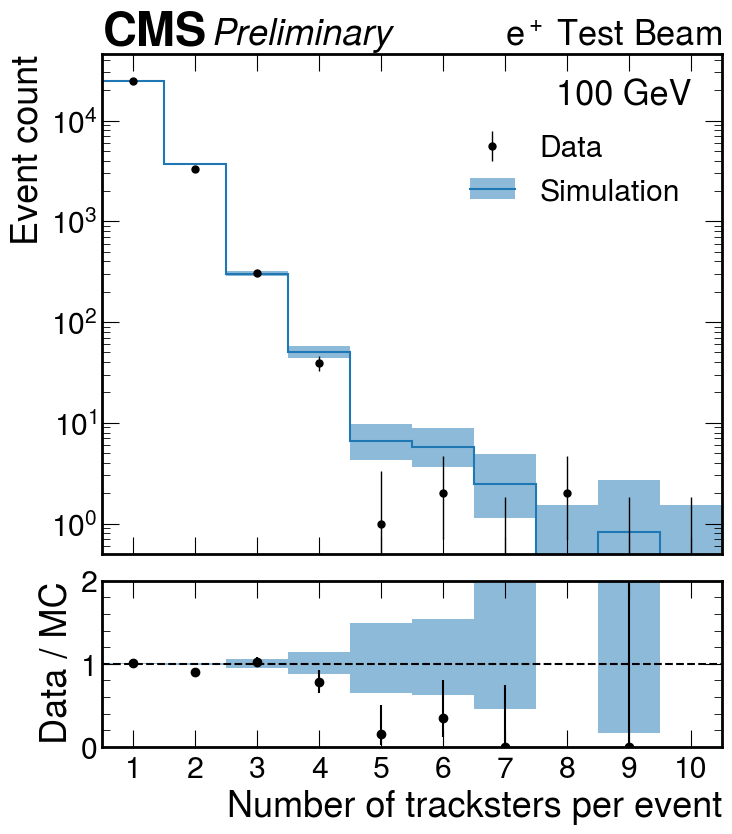

In [29]:
#nbOfTracksterPerEvent_definitive(20)
#nbOfTracksterPerEvent_definitive(100)
plt.savefig("plots/tracksterProps/nbOfTrackstersPerEvent/100.pdf", bbox_inches="tight")
with matplotlib.rc_context({"figure.figsize" : (7, 7)}):
    nbOfTracksterPerEvent_definitive(100)
    plt.savefig("plots/tracksterProps/nbOfTrackstersPerEvent/100_small.pdf", bbox_inches="tight")
nbOfTracksterPerEvent_ratio(100)
plt.savefig("plots/tracksterProps/nbOfTrackstersPerEvent/100_ratio.pdf", bbox_inches="tight")
#nbOfTracksterPerEvent_definitive(200)